In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Flatten
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import copy
from tensorflow.keras.callbacks import Callback
from sklearn.manifold import TSNE

# change here if needed
LATENT_DIM = 128
NOISE_DIM = 32
IMAGE_SIZE = 64

Mounted at /content/drive/


In [2]:
# Helper function
def load_images(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            img = img[:,:,::-1]
            img_array = np.array(img) / 255.0
            image_list.append(img_array)
    return np.array(image_list)

class PlotReconstructedImages(Callback):
    def __init__(self, x_val, interval=20):
        super().__init__()
        self.x_val = x_val
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            reconstructed_images = self.model.predict(self.x_val)
            self.plot_images(reconstructed_images)

    def plot_images(self, reconstructed_images):
        n = 10
        plt.figure(figsize=(20, 4))

        for i in range(n):
            # Display original images
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(self.x_val[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Display reconstructed images
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed_images[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()

In [3]:
# Load other data if VAE data are diff with GANs data
folder_path = "/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/data/smd"
#folder_path_GANs = "/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/data/animefaces256cleaner"
x_data_1 = load_images(folder_path)
#x_data_2 = load_images(folder_path_GANs)

In [ ]:
#x_data_2 = x_data_2[:1500]

In [5]:
# x_data_VAE = np.concatenate((x_data_1, x_data_2), axis=0)
x_data_VAE = x_data_1
x_data_GAN = x_data_1

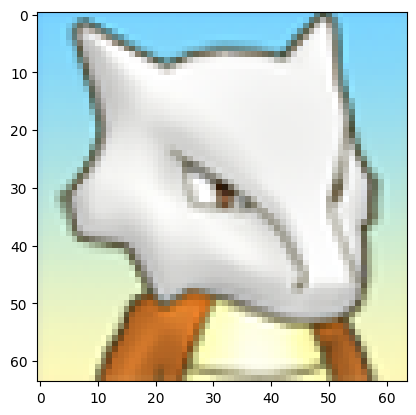

In [ ]:
plt.imshow(x_data_GAN[-1])

In [ ]:
# Encoder
encoder_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)

z_mean = Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = Dense(LATENT_DIM, name="z_log_var")(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_input = Input(shape=(LATENT_DIM,))
x = Reshape((1, 1, LATENT_DIM))(decoder_input)

x = Conv2DTranspose(512, 4, activation="relu", padding="valid")(x)
x = Conv2DTranspose(256, 4, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 4, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
decoder_output = Conv2DTranspose(3, 4, activation="sigmoid", padding="same")(x)

decoder = Model(decoder_input, decoder_output, name="decoder")

# VAE
vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name="vae")

# Loss
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_input, vae_output))
reconstruction_loss *= IMAGE_SIZE * IMAGE_SIZE
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile
vae.add_loss(vae_loss)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.99)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
vae.compile(optimizer = optimizer)

plot_callback = PlotReconstructedImages(x_data_VAE, interval=20)

epochs = 400
batch_size = 256
history = vae.fit(x_data_VAE, x_data_VAE, epochs=epochs, batch_size=batch_size,callbacks=[plot_callback])

(1, 128)
1/1 [==============================] - 0s 21ms/step


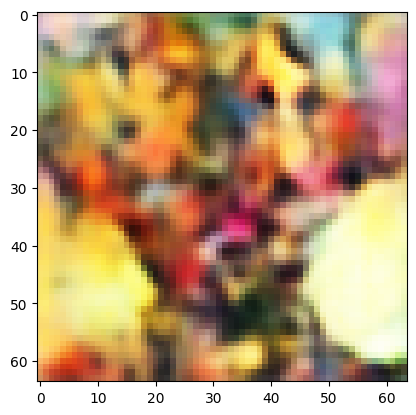

In [ ]:
# Check random sampling
def sampling_fromnp(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), dtype=tf.double)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
# Generate a random z_mean and z_log_var for demonstration
z_mean_example = np.random.normal(0, 1, (1, LATENT_DIM))
z_log_var_example = np.random.normal(0, 1, (1, LATENT_DIM))

# Obtain a sample from the latent space
z_sample = sampling_fromnp(z_mean_example, z_log_var_example)
print(z_sample.shape)
# Generate an image using the decoder
generated_image = decoder.predict(z_sample)

# Display the generated image
plt.imshow(generated_image[0])
plt.show()

5/5 [==============================] - 0s 21ms/step


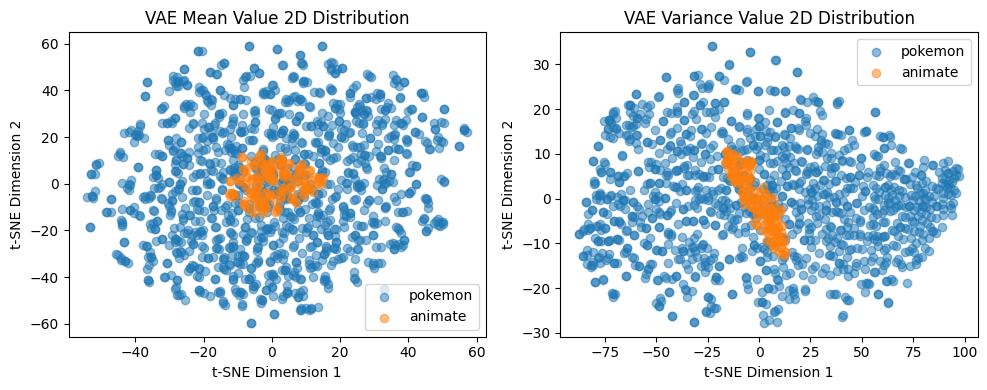

In [ ]:
# Plot the 2D distribution
split_index = x_data_VAE.shape[0] - 1500

smd = x_data_VAE[:split_index]
animate = x_data_VAE[split_index:]

z_mean_smd, z_log_var_smd, z_smd = encoder.predict(smd)
z_mean_animate, z_log_var_animate, z_animate = encoder.predict(animate)

# Perform t-SNE dimensionality reduction
z_mean_2d_smd = TSNE(n_components=2).fit_transform(z_mean_smd)
z_log_var_2d_smd = TSNE(n_components=2).fit_transform(z_log_var_smd)

z_mean_2d_animate = TSNE(n_components=2).fit_transform(z_mean_animate)
z_log_var_2d_animate = TSNE(n_components=2).fit_transform(z_log_var_animate)

# Plot the 2D distribution of the latent space
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(z_mean_2d_smd[:, 0], z_mean_2d_smd[:, 1], alpha=0.5, label = "pokemon")
axs[0].scatter(z_mean_2d_animate[:, 0], z_mean_2d_animate[:, 1], alpha=0.5, label = "animate")
axs[0].set_title("VAE Mean Value 2D Distribution")
axs[0].set_xlabel("t-SNE Dimension 1")
axs[0].set_ylabel("t-SNE Dimension 2")
axs[0].legend()

axs[1].scatter(z_log_var_2d_smd[:, 0], z_log_var_2d_smd[:, 1], alpha=0.5, label = "pokemon")
axs[1].scatter(z_log_var_2d_animate[:, 0], z_log_var_2d_animate[:, 1], alpha=0.5, label = "animate")
axs[1].set_title("VAE Variance Value 2D Distribution")
axs[1].set_xlabel("t-SNE Dimension 1")
axs[1].set_ylabel("t-SNE Dimension 2")
axs[1].legend()

plt.tight_layout()
plt.show()

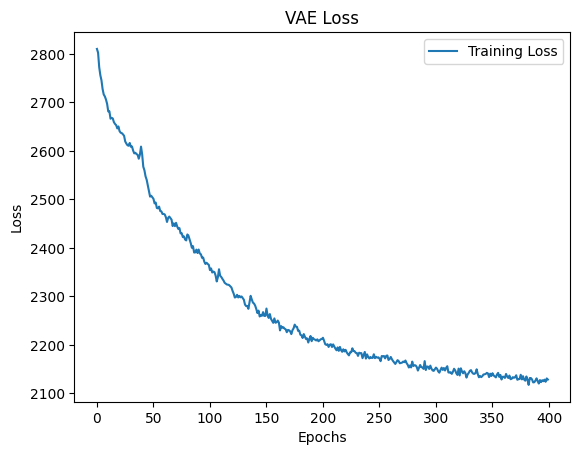

In [ ]:
# Plot training loss 
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Loss')
plt.show()

In [ ]:
decoder.save('/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/decoder_model_smd_128_April.h5')

In [25]:
# Load the decoder model
decoder = load_model('/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/decoder_model_smd_128_April.h5')

dataset_GANs = tf.data.Dataset.from_tensor_slices(x_data_GAN)

# Set the batch size
BATCH_SIZE = 256
dataset_GANs = dataset_GANs.shuffle(buffer_size=1024).batch(BATCH_SIZE)

def denormalize(image):
    return image

def display_image(image):
    denorm_image = denormalize(image)
    plt.imshow(denorm_image)
    plt.axis('off')
    plt.show()

def display_batch(images, title):
    fig = plt.figure(figsize=(6, 6))
    plt.suptitle(title)

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import InputLayer, Lambda, Dense, Flatten,LeakyReLU,Conv2D,Activation,BatchNormalization, Dropout, ReLU

def generator(decoder, noise_dim=NOISE_DIM):
    """
    Generate image from noise 
    Inputs:
    - decoder: pretrain model for genrate image freom mean and std
    - noise_dim: the dimension of the noise 
    
    Returns:
    TensorFlow Tensor with shape [number of image in one batch, 64, 64, 3]
    """

    # Freeze layers in the saved model
    for i, layer in enumerate(decoder.layers):

        # Check layers
        if i <= 3:
          layer.trainable = False
        else:
          layer.trainable = False
        
        layer._name = f'saved_model_{i}_{layer.name}'

    model = Sequential([
        tf.keras.Input(shape=noise_dim),
        Dense(128, activation=ReLU()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation=ReLU()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation=ReLU()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(LATENT_DIM, activation=ReLU()),
        #Dense(LATENT_DIM*2, activation=LeakyReLU()),
        #Lambda(lambda x: sampling([x[:, :LATENT_DIM], x[:, LATENT_DIM:]]))
        Reshape((1, LATENT_DIM))
    ])
    
    # Add layers from the saved model
    for layer in decoder.layers:
        model.add(layer)

    model.add(Activation('tanh'))

    return model

from keras.layers.serialization import activation
def discriminator(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)):
  
    """Compute discriminator score for a batch of input images.
      
    Inputs:
    - x: tensor, shape [number of images in one batch, 64, 64, 3]
    
    Returns:
    TensorFlow Tensor with shape [number of images in one batch, 1], containing the score 
    for an image being real for each input image.
    """

    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Reshape((IMAGE_SIZE,IMAGE_SIZE,3), input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',input_shape = input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dense(1,activation = "sigmoid"))

    return model

In [26]:
def generator_loss(fake_score):
    # We use Wassertein loss here 
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_score), fake_score)

def disciminator_loss(real_score,fake_score):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_score), real_score)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_score), fake_score)

    return fake_loss + real_loss

@tf.function
def train_G(noise,generator_model,discriminator_model,generator_optimizer):
  with tf.GradientTape() as gen_tape:
    fake_images = generator_model(noise, training=True)
    fake_score = discriminator_model(fake_images, training=False)
    G_loss = generator_loss(fake_score)

  generator_gradients = gen_tape.gradient(G_loss, generator_model.trainable_weights)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_weights))
  return G_loss,fake_images

@tf.function
def train_D(noise,real_images,generator_model,discriminator_model,discriminator_optimizer):

  with tf.GradientTape() as dis_tape:
    fake_images = generator_model(noise, training=False)
    real_score = discriminator_model(real_images, training=True)
    fake_score = discriminator_model(fake_images, training=True)
    D_loss = disciminator_loss(real_score,fake_score)
    disciminator_gradients = dis_tape.gradient(D_loss, discriminator_model.trainable_weights)

  discriminator_optimizer.apply_gradients(zip(disciminator_gradients, discriminator_model.trainable_weights))

  
  return D_loss,real_score,fake_score

def train_gan(dataset, generator_model, discriminator_model, generator_optimizer,discriminator_optimizer, epochs):
  history_GL = []
  history_FS = []
  history_DL = []
  history_RS = []

  for epoch in range(epochs):
    gen_loss_sum = 0
    disc_loss_sum = 0
    num_batches = 0
    fake_score_sum = 0
    real_score_sum = 0

    for image_batch in dataset:
      for _ in range(1):
        noise = tf.random.normal([image_batch.shape[0], NOISE_DIM])
        D_loss,real_score,fake_score = train_D(noise,image_batch,generator_model,discriminator_model,discriminator_optimizer)
      
      for _ in range(4):
        noise = tf.random.normal([image_batch.shape[0], NOISE_DIM])
        G_loss,fake_images = train_G(noise,generator_model,discriminator_model,generator_optimizer)

      gen_loss_sum += G_loss
      disc_loss_sum += D_loss
      num_batches += 1
      fake_score_sum += np.mean(fake_score.numpy())
      real_score_sum += np.mean(real_score.numpy())

    if epoch % 5 == 0:
      generated_images = fake_images.numpy()[0:9]
      denorm_images = [denormalize(img) for img in generated_images]
      display_batch(denorm_images, f"Generated images at epoch {epoch + 1}")

    history_GL.append(gen_loss_sum/num_batches)
    history_FS.append(fake_score_sum/num_batches)
    history_DL.append(disc_loss_sum/num_batches)
    history_RS.append(real_score_sum/num_batches)

    print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_sum/num_batches}, fake score: {fake_score_sum/num_batches}, Discriminator Loss: {disc_loss_sum/num_batches}, real score: {real_score_sum/num_batches}')
  
  return history_GL, history_FS, history_DL, history_RS

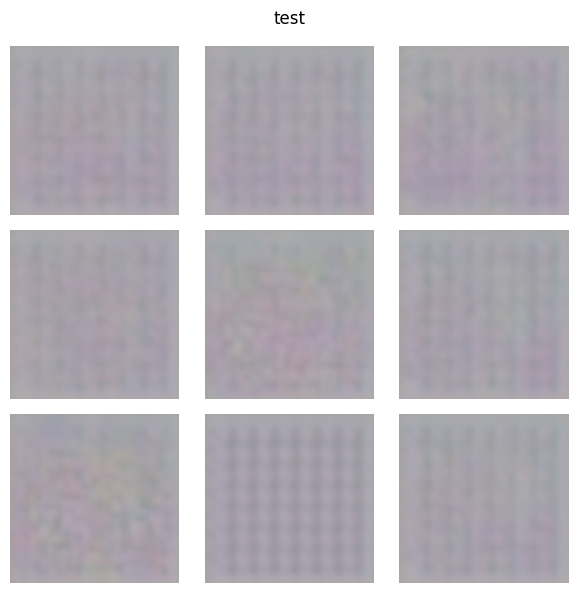

tf.Tensor(
[[0.45378804]
 [0.614138  ]
 [0.6739068 ]
 [0.46382418]
 [0.3909779 ]
 [0.69040704]
 [0.64069587]
 [0.9293705 ]
 [0.6654188 ]
 [0.9044796 ]], shape=(10, 1), dtype=float32)
tf.Tensor(0.47763342, shape=(), dtype=float32)


In [27]:
generator_model = generator(decoder)
noise = tf.random.normal([10, NOISE_DIM])
fake_images = generator_model(noise,training=False)
generated_images = fake_images.numpy()[0:9]
denorm_images = [denormalize(img) for img in generated_images]
display_batch(denorm_images,"test")

discriminator_model = discriminator()
fake_score = discriminator_model(fake_images, training=True)
print(fake_score)
print(generator_loss(fake_score))

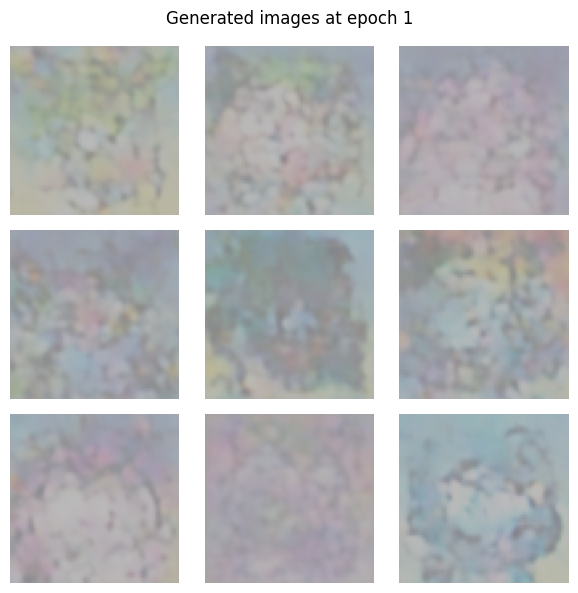

Epoch 1, Generator Loss: 0.6826057434082031, fake score: 0.2941886993745963, Discriminator Loss: 0.9361570477485657, real score: 0.6528002421061198
Epoch 2, Generator Loss: 0.7047839164733887, fake score: 0.0778933862845103, Discriminator Loss: 0.5400926470756531, real score: 0.6774581670761108
Epoch 3, Generator Loss: 0.7139298319816589, fake score: 0.06466601726909478, Discriminator Loss: 0.376434326171875, real score: 0.76153031984965
Epoch 4, Generator Loss: 0.7238537669181824, fake score: 0.029255307279527187, Discriminator Loss: 0.2431054264307022, real score: 0.8248076736927032
Epoch 5, Generator Loss: 0.7262572646141052, fake score: 0.016544369670252006, Discriminator Loss: 0.15978898108005524, real score: 0.8769981563091278


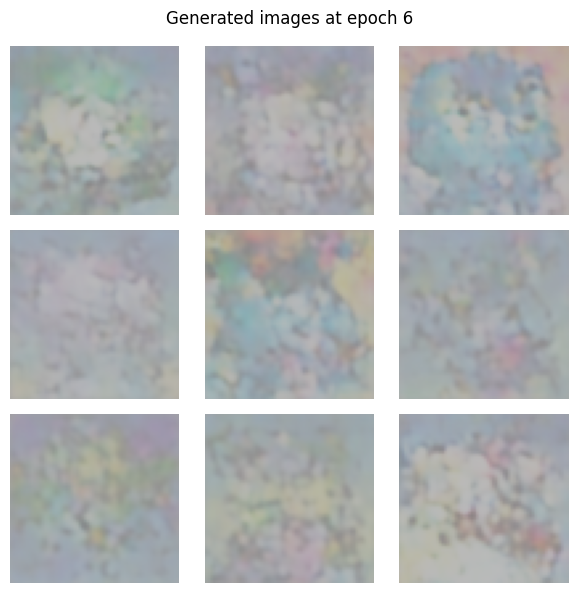

Epoch 6, Generator Loss: 0.7214517593383789, fake score: 0.012516209700455269, Discriminator Loss: 0.11475285142660141, real score: 0.9096334675947825
Epoch 7, Generator Loss: 0.7121458649635315, fake score: 0.012597025216867527, Discriminator Loss: 0.08592245727777481, real score: 0.9341451426347097
Epoch 8, Generator Loss: 0.6980059742927551, fake score: 0.012417988541225592, Discriminator Loss: 0.06699308007955551, real score: 0.9501900573571523
Epoch 9, Generator Loss: 0.6809019446372986, fake score: 0.012423946677396694, Discriminator Loss: 0.05779469385743141, real score: 0.9585274159908295
Epoch 10, Generator Loss: 0.662567675113678, fake score: 0.012529848609119654, Discriminator Loss: 0.049449265003204346, real score: 0.9658146401246389


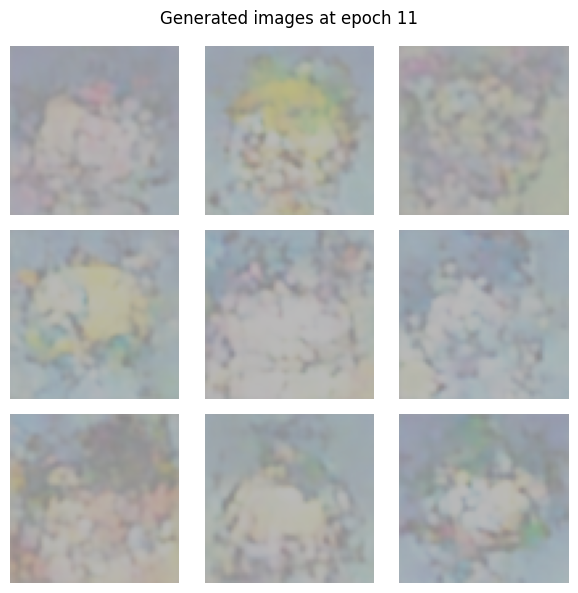

Epoch 11, Generator Loss: 0.6423376798629761, fake score: 0.010973257788767418, Discriminator Loss: 0.043869782239198685, real score: 0.9692391554514567
Epoch 12, Generator Loss: 0.6203723549842834, fake score: 0.010729370017846426, Discriminator Loss: 0.04011235758662224, real score: 0.9725615183512369
Epoch 13, Generator Loss: 0.596304178237915, fake score: 0.009926386643201113, Discriminator Loss: 0.0373070202767849, real score: 0.9743719696998596
Epoch 14, Generator Loss: 0.5698997974395752, fake score: 0.00890491895067195, Discriminator Loss: 0.034112609922885895, real score: 0.9762756725152334


KeyboardInterrupt: ignored

In [28]:
generator_model = generator(decoder)
discriminator_model = discriminator()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
history_GL, history_FS, history_DL, history_RS = train_gan(dataset_GANs, generator_model, discriminator_model,generator_optimizer,discriminator_optimizer, epochs=500)

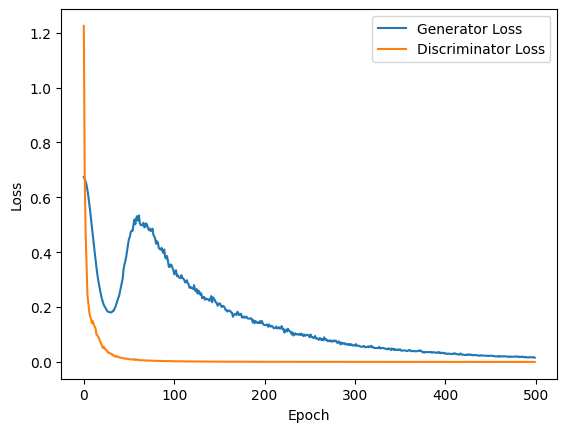

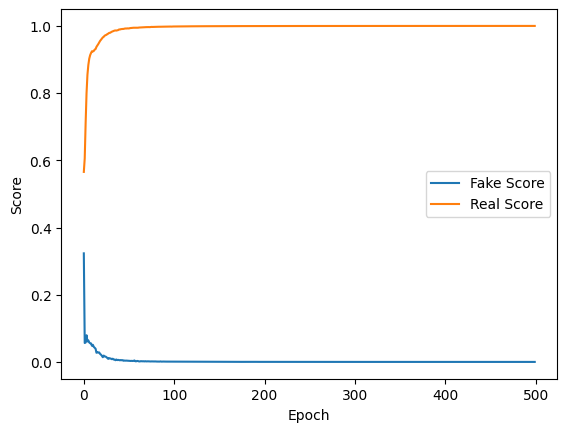

In [19]:
plt.figure()
plt.plot(history_GL, label="Generator Loss")
plt.plot(history_DL, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Fake Score and Real Score
plt.figure()
plt.plot(history_FS, label="Fake Score")
plt.plot(history_RS, label="Real Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()